In [1]:
from utils import Polarity

import pandas as pd
import numpy as np

from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid", {'grid.linestyle': '--'})

In [3]:
df = pd.read_csv('../political_news.csv', parse_dates=['date'])
vecs = np.load('../training/bestmod_vecs.npy')

polarity_obj = Polarity(df, vecs, period_length='1d', standartize_vecs=True)
polarity_df = polarity_obj.get_polarity()

In [4]:
colors = [
    '#1f77b4',  # blue
    '#ff7f0e',  # orange
    '#2ca02c',  # green
    '#d62728',  # red
    '#9467bd',  # purple
    '#8c564b',  # brown
    '#e377c2',  # pink
    '#7f7f7f',  # gray
    '#bcbd22',  # olive
    '#17becf',  # light blue
    '#ff9896',  # light orange
    '#98df8a',  # light green
    '#ffbb78',  # light red
    '#c5b0d5',  # light purple
    '#c49c94'   # light brown
]
comb_colors_dict = {v:k for v,k in zip(polarity_obj.combs, colors)}

In [ ]:
polarity_df['D_rolling'] = polarity_df.groupby('comb', group_keys=False)['D'].apply(lambda x: x.rolling(30).mean())
polarity_df['B_rolling'] = polarity_df.groupby('comb', group_keys=False)['B'].apply(lambda x: x.rolling(30).mean())
polarity_df['cluster'] = polarity_df['between_combs'].map({True:'Between', False:'Within'})

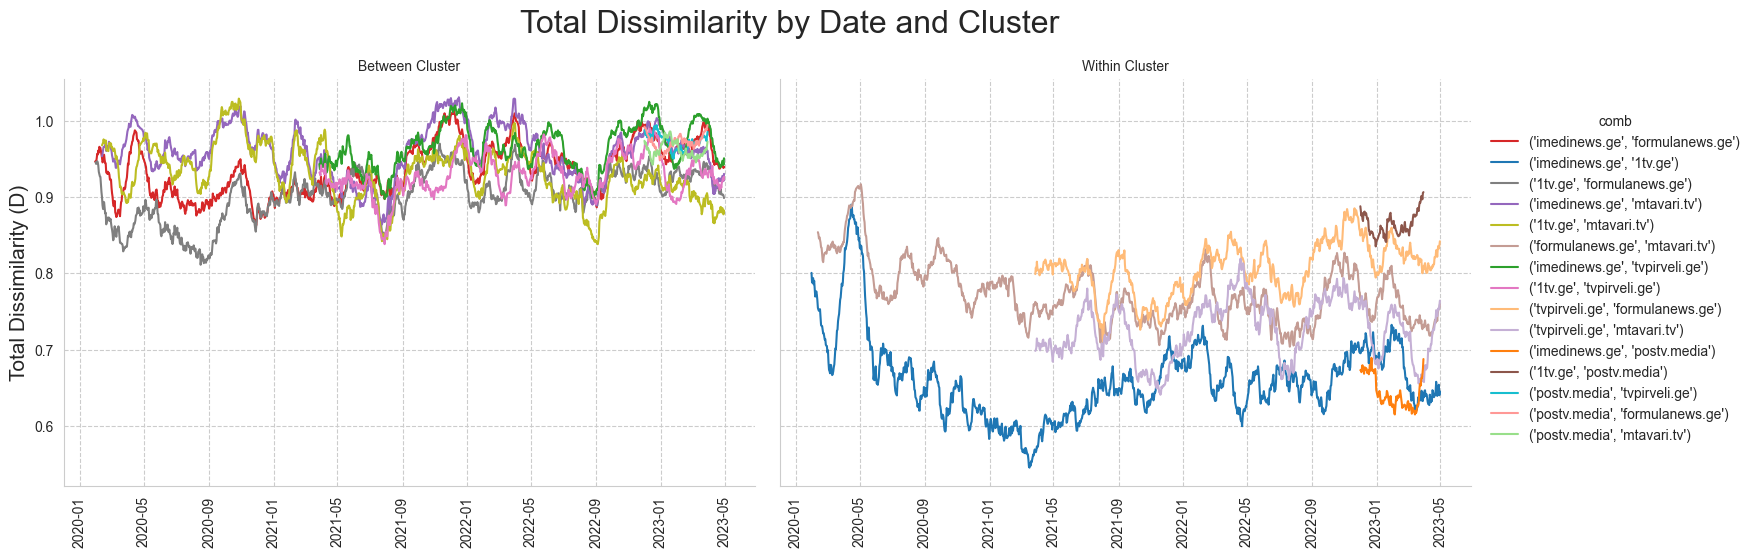

In [9]:
g = sns.relplot(data=polarity_df, x='date', y='D_rolling', col='cluster', hue='comb',
            kind='line', aspect=1.5, palette=comb_colors_dict)

g.set_titles("{col_name} Cluster")
g.set_axis_labels("", "Total Dissimilarity (D)", fontsize=15)

g.fig.suptitle("Total Dissimilarity by Date and Cluster", x=0.455, y=1.07, fontsize=23)

for ax in g.axes.flatten():
    ax.tick_params(axis='x', rotation=90);

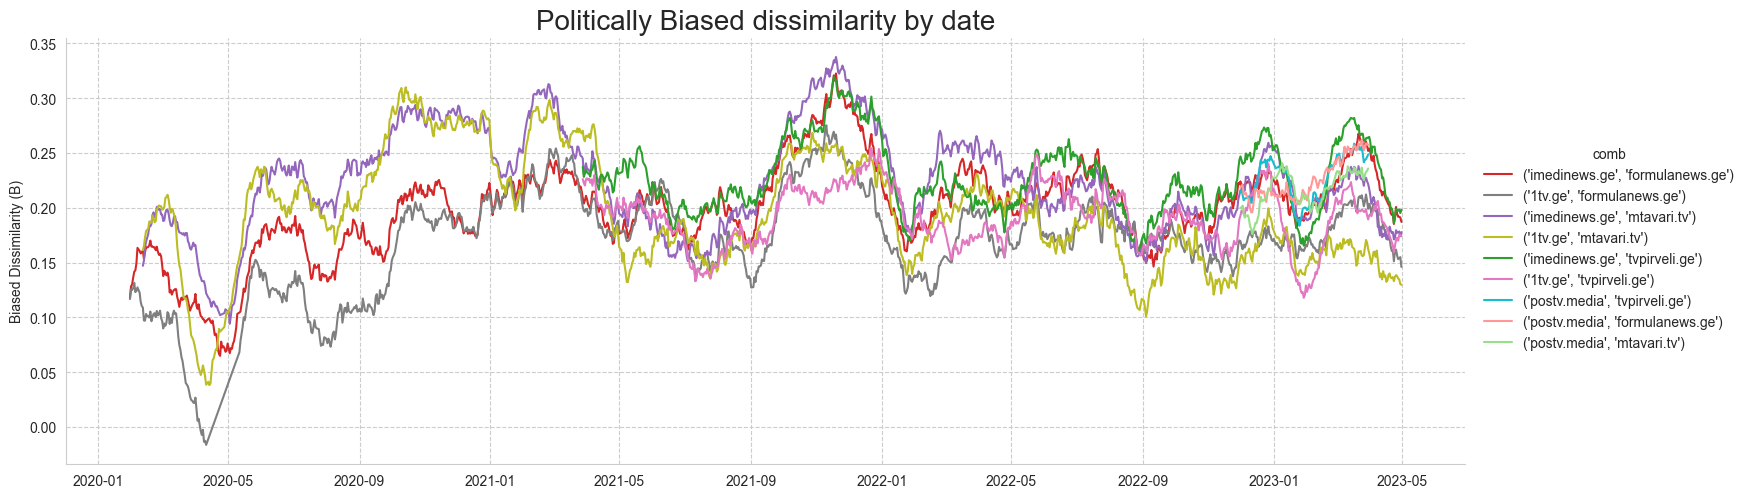

In [7]:
sns.relplot(data=polarity_df[polarity_df['between_combs']], x='date', y='B_rolling', hue='comb',
            kind='line', aspect=3, palette=comb_colors_dict)
plt.xlabel('')
plt.ylabel('Biased Dissimilarity (B)')
plt.title('Politically Biased dissimilarity by date', fontsize=20);

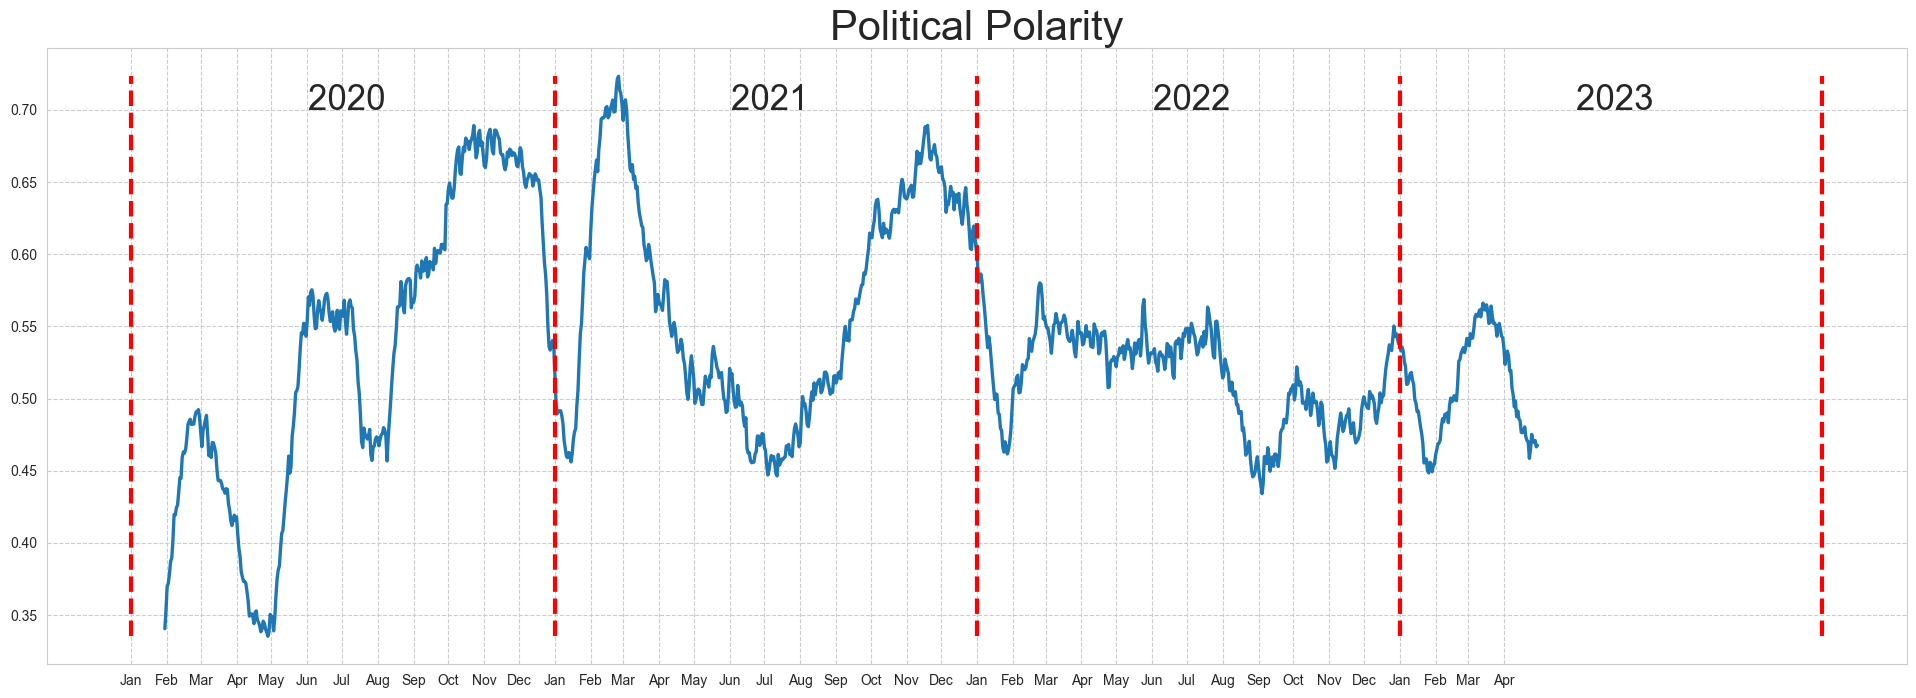

In [15]:
def normalize_column(col):
    return (col - col.min())/(col.max()-col.min())

agg_polarity = polarity_df.groupby('date').agg({'polarity':'sum'})
agg_polarity['polarity'] = normalize_column(agg_polarity['polarity'])
agg_polarity['polarity_rolling'] = agg_polarity['polarity'].rolling(30).mean()

fig, ax = plt.subplots(figsize=[24,8])
ax.plot(agg_polarity['polarity_rolling'], lw=2.4)
for year in [2020, 2021, 2022, 2023, 2024]:
    ax.plot([datetime(year, 1, 1), datetime(year, 1, 1)],
            [agg_polarity['polarity_rolling'].min(), agg_polarity['polarity_rolling'].max()], c='r', lw=3, linestyle='--')
    ax.annotate(year, xy=(datetime(year,6, 2), 0.7), fontsize=25)

ax.set_xticks([date for date in agg_polarity.index if date.day == 1])
ax.set_xticklabels([date.strftime('%b') for date in agg_polarity.index if date.day == 1])
ax.grid(True, linestyle='--')
ax.set_title('Political Polarity', fontsize=30);

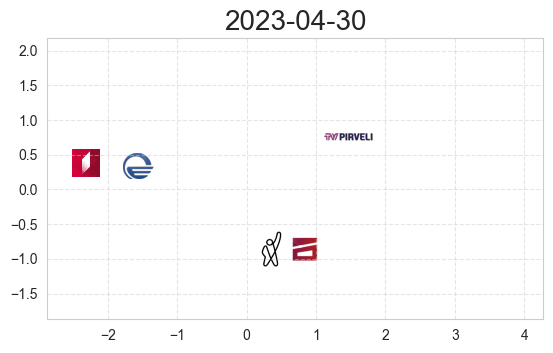

In [14]:
polarity_obj.save_animation()